In [1]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import local_acq1, generate1, log_likelihood, get_likelihood_utility

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

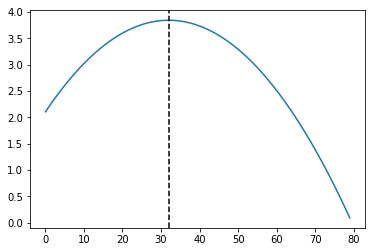

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [5]:
learning_rate_params = np.array([0, 350, 350])
stay_penalty_params = np.array([10, 0, 10])
temp_params = np.array([.01, .01, .01])

In [6]:
true_params = {'learning_rate': learning_rate_params,
                   'stay_penalty': stay_penalty_params,
                   'temperature': temp_params}

In [7]:
data = generate1(local_acq1, true_params, neg_quad_kern, neg_quad, 30, 20, 3, np.array([.333, .333, .333]))

In [8]:
actions = data[:,9,:].argmax(axis=1)

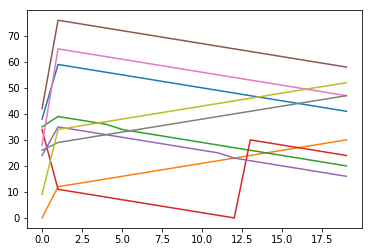

In [9]:
plt.plot(actions[:9].T);

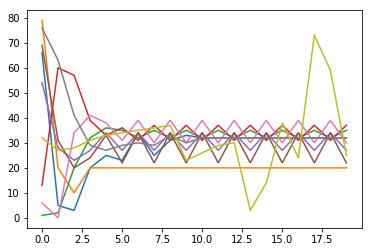

In [10]:
plt.plot(actions[10:19].T);

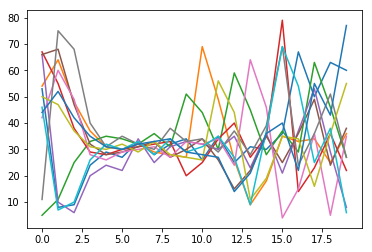

In [11]:
plt.plot(actions[19:].T);

## Infinite Mixture

In [40]:
rerun_inf_mix = False

In [13]:
k=30

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [14]:
if rerun_inf_mix:
    with pm.Model() as model:
        learning_rate = pm.Gamma('learning_rate', 25., .1, shape=k)
        stay_penalty = pm.Gamma('stay_penalty', .1, .1, shape=k)
        temperature = pm.Gamma('temperature', .1, .1, shape=k)
        
        alpha = pm.Gamma('alpha', 1., 1.)
        beta = pm.Beta('beta', 1., alpha, shape=k)
        w = pm.Deterministic('w', stick_breaking(beta))

        obs = pm.Potential('obs', log_likelihood(data, local_acq1, {'learning_rate': learning_rate, 
                                   'temperature': temperature, 'stay_penalty': stay_penalty}, k, w))
        inf_mix_trace = pm.sample(200)
        with open('local_inf_mix_trace.pkl', 'wb') as f:
            pickle.dump(inf_mix_trace, f)
else:
    with open('local_inf_mix_trace.pkl', 'rb') as f:
        inf_mix_trace = pickle.load(f)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4184' (I am process '5852')
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [28:31:26<00:00, 156.43s/draws]  
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9232531547764201, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8832211850271275, but should be close to 0.8. Try to increase the number of tuning steps.
The cha

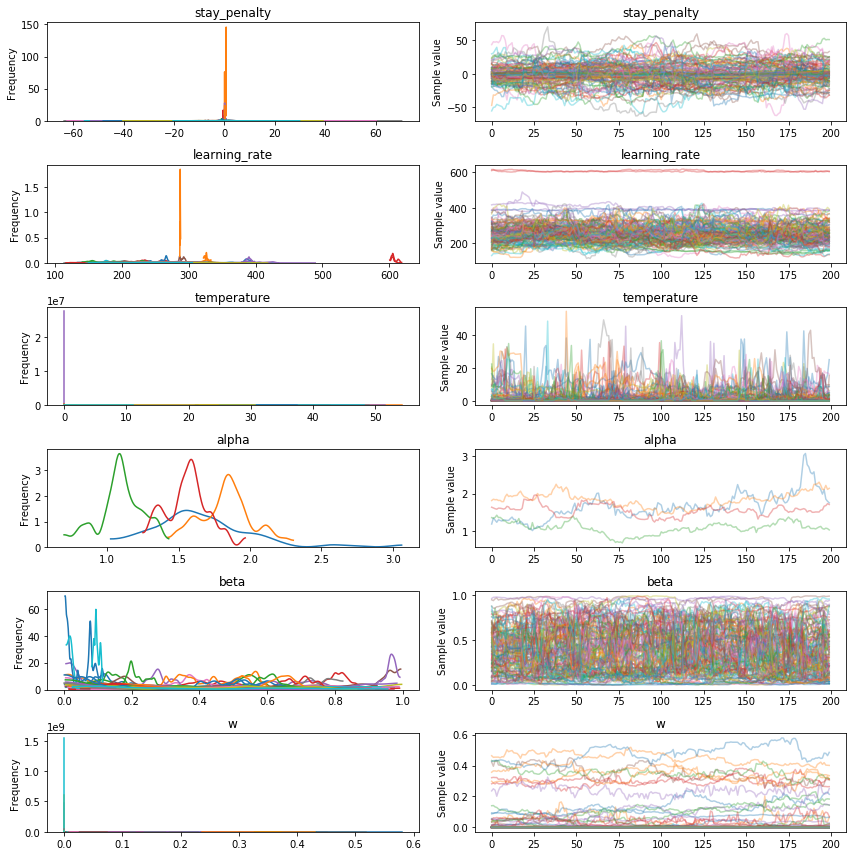

In [15]:
pm.traceplot(inf_mix_trace);

### Components

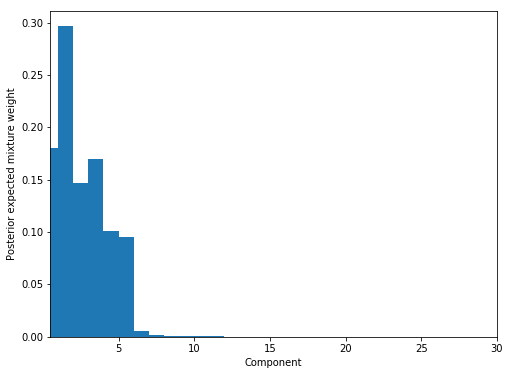

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_w = np.arange(k) + 1
ax.bar(plot_w - 0.5, inf_mix_trace['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, k);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

### Recovered Strategies

In [35]:
def local_clusters(trace, threshold):
    
    mean_weights = trace['w'].mean(axis=0)
    idx = np.argwhere(mean_weights>=threshold).ravel()
    samples = np.array([[s['learning_rate'], s['stay_penalty'], s['temperature']] for s in np.array(trace)])[:,:,idx]
    
    return samples

In [47]:
samples = local_clusters(inf_mix_trace, .15)

In [48]:
mean = samples.mean(axis=0)

In [49]:
mean

array([[ 2.64715728e+02,  3.21601104e+02,  2.56067812e+02],
       [-9.27177331e-01,  7.28117967e-02, -8.44126511e+00],
       [ 2.66608079e-01,  1.02856986e-01,  1.17318261e+00]])

In [50]:
learned_params = true_params = {'learning_rate': mean[0],
                   'stay_penalty': mean[1],
                   'temperature': mean[2]}

In [51]:
new_data = generate1(local_acq1, learned_params, neg_quad_kern, neg_quad, 30, 20, 3, np.array([.333, .333, .333]))

In [54]:
new_actions = new_data[:,9,:].argmax(axis=1)

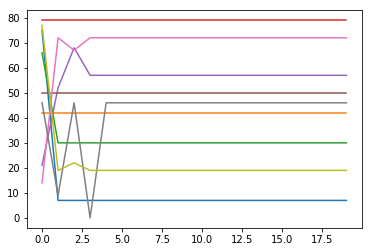

In [55]:
plt.plot(new_actions[:9].T);

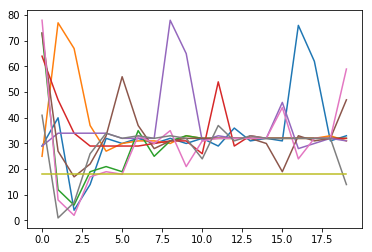

In [58]:
plt.plot(new_actions[10:19].T);

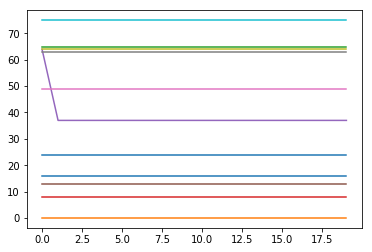

In [59]:
plt.plot(new_actions[19:].T);